# Predicting Wildfire Magnitude

Aim: We want to predict the magnitude of forest fires from factors such as location, physical conditions up to and during and cause of fire etc using a regression neural network.

Purpose: With this model it will be easier for affected parties (e.g. insurance companies, councils and families) to deal with its aftermath.

Extension: We could try to estimate potential economic loss using the magnitude prediction.

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredLogarithmicError

In [179]:
# import data
df = pd.read_csv("./FW_Veg_Rem_Combined.csv")

# restrict to california
df_CA = df[df['state'] == 'CA']

# clean data - remove unwanted columns

columns_to_keep = ["latitude", "Temp_pre_7", "Temp_cont",
                   "Wind_pre_7", "Wind_cont", "Hum_pre_7", "Hum_cont", "Prec_pre_7", "Prec_cont", "fire_mag"]

df_clean = df_CA[columns_to_keep]

# even out proportions of magnitudes
value_counts = df_clean['fire_mag'].value_counts()

# Find the least common value and the count of the most common value
min_count = value_counts.min()
max_count = value_counts.max()

resampled_df = pd.DataFrame()

for value in df_clean['fire_mag'].unique():
    # Get a subset of the original DataFrame for the current value
    subset = df_clean[df_clean['fire_mag'] == value]
    
    # If the count is less than the maximum count, create random samples to match the max_count
    if value_counts[value] < max_count:
        samples = subset.sample(n=max_count - value_counts[value], replace=True, random_state=42)
        subset = pd.concat([subset, samples], ignore_index=True)
    
    # Append the subset to the resampled DataFrame
    resampled_df = resampled_df.append(subset, ignore_index=True)

# randomise which datapoints are in the train and which is in the test
shuffled_indices = np.random.permutation(len(resampled_df))
df_shuffled = resampled_df.iloc[shuffled_indices]
cat_columns = df_shuffled.select_dtypes(include=["object"]).columns

train_perc = 0.8

train_data = df_shuffled[:int(train_perc * len(df_shuffled))] # last n is train data
test_data = df_shuffled[int(train_perc * len(df_shuffled)):] # first N - n is test data

x_train = train_data.drop("fire_mag", axis=1, inplace=False)
x_test = test_data.drop("fire_mag", axis=1, inplace=False)

y_train = train_data["fire_mag"]
y_test = test_data["fire_mag"]

x_train

/tmp/ipykernel_1961/2549461730.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  resampled_df = resampled_df.append(subset, ignore_index=True)


,latitude,Temp_pre_7,Temp_cont,Wind_pre_7,Wind_cont,Hum_pre_7,Hum_cont,Prec_pre_7,Prec_cont
1621,34.200000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0
3102,36.901944,23.486310,27.683171,3.556548,3.019332,45.625000,39.689847,0.0,0.0
6352,32.701667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
9395,37.268056,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0
8152,37.088333,24.750595,0.000000,1.639286,0.000000,49.589286,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...
5306,40.450000,0.000000,20.000000,0.000000,2.600000,0.000000,39.000000,0.0,0.0
8119,37.713889,19.021505,19.801418,4.405435,4.108983,65.869565,63.071090,0.0,0.0
6665,36.687835,23.118421,23.430992,2.379605,2.081956,46.059211,51.445367,0.0,1.0
6148,37.021111,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.0


In [180]:
# may have to experiment with parameters
hidden_units1 = 10
hidden_units2 = 100
hidden_units3 = 75
learning_rate = 0.0001

# create model using the Sequential in tensorflow
# have used relu as outplut layer because we want a positive value as an output of magnitude
def build_model_using_sequential():
    model = Sequential([Dense(hidden_units1, kernel_initializer='normal', activation=tf.nn.relu), Dropout(0.2),
                        Dense(hidden_units2, kernel_initializer='normal', activation=tf.nn.relu), Dropout(0.2),
                        Dense(hidden_units3, kernel_initializer='normal', activation=tf.nn.relu),
                        Dense(1, kernel_initializer='normal', activation='relu')])
    return model

model = build_model_using_sequential()

In [181]:
# loss function
msle = MeanSquaredLogarithmicError()
model.compile(loss=msle, optimizer=SGD(learning_rate=learning_rate), metrics=[msle])

# train the model
history = model.fit(x_train.values, y_train.values, epochs=100, batch_size=64,validation_split=0.2)

Epoch 1/100
153/153 [==============================] - 1s 2ms/step - loss: 7.1239 - mean_squared_logarithmic_error: 7.1236 - val_loss: 6.8989 - val_mean_squared_logarithmic_error: 6.8095
Epoch 2/100
153/153 [==============================] - 0s 923us/step - loss: 6.4426 - mean_squared_logarithmic_error: 6.4444 - val_loss: 6.0334 - val_mean_squared_logarithmic_error: 5.9520
Epoch 3/100
153/153 [==============================] - 0s 911us/step - loss: 5.5183 - mean_squared_logarithmic_error: 5.5155 - val_loss: 5.0071 - val_mean_squared_logarithmic_error: 4.9367
Epoch 4/100
153/153 [==============================] - 0s 923us/step - loss: 4.6119 - mean_squared_logarithmic_error: 4.6096 - val_loss: 4.1597 - val_mean_squared_logarithmic_error: 4.1000
Epoch 5/100
153/153 [==============================] - 0s 916us/step - loss: 3.9525 - mean_squared_logarithmic_error: 3.9512 - val_loss: 3.6021 - val_mean_squared_logarithmic_error: 3.5512
Epoch 6/100
153/153 [==============================] - 0s

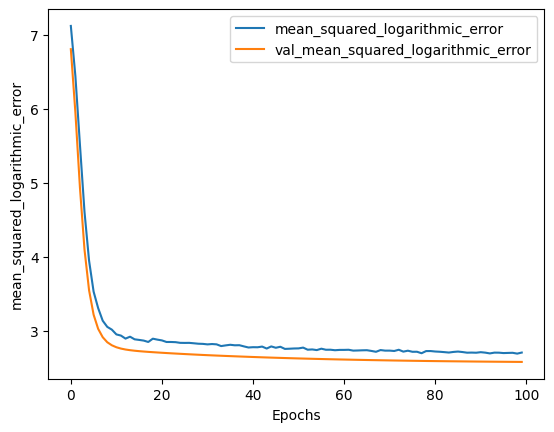

In [182]:
def plot_history(history, key):
    plt.plot(history.history[key])
    plt.plot(history.history['val_'+key])
    plt.xlabel("Epochs")
    plt.ylabel(key)
    plt.legend([key, 'val_'+key])
    plt.show()
# Plot the history
plot_history(history, 'mean_squared_logarithmic_error')

In [183]:
# predict data
pred_values = model.predict(x_test)

96/96 [==============================] - 0s 358us/step


In [187]:
print(abs(pred_values - y_test.to_numpy()))

[[ 1.83257294 45.16742706 95.16742706 ... 95.16742706  1.83257294
   4.73257294]
 [ 6.77814865 40.22185135 90.22185135 ... 90.22185135  6.77814865
   9.67814865]
 [ 3.96666479 43.03333521 93.03333521 ... 93.03333521  3.96666479
   6.86666479]
 ...
 [ 4.4633956  42.5366044  92.5366044  ... 92.5366044   4.4633956
   7.3633956 ]
 [ 0.37054873 46.62945127 96.62945127 ... 96.62945127  0.37054873
   3.27054873]
 [ 4.0810976  42.9189024  92.9189024  ... 92.9189024   4.0810976
   6.9810976 ]]
